## Binary Classification

In [60]:
#Importing dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [61]:
X, y = mnist['data'], mnist['target']
print(f'Data shapes: X = {X.shape}, y = {y.shape}')

Data shapes: X = (70000, 784), y = (70000,)


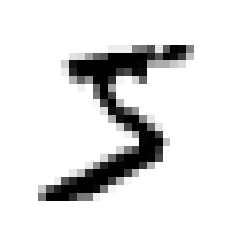

label:  5


In [62]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X.loc[0]
some_digit_image = np.reshape(some_digit.values, (28,28))
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()
print("label: ",y[0])

In [63]:
#Casting labels to integers
print("Type before casting: ",type(y[0]))
y = y.astype(np.uint8)

Type before casting:  <class 'str'>


Before Inspecting data, let's create train and test set splits. Training set here is already shuffled

In [64]:
set_split = 60000

X_train, X_test, y_train, y_test = X[:set_split], X[set_split:], y[:set_split], y[set_split:]

### Simplifying problem to binary classification:

Let's train a model to classify 5 and not-5

In [65]:
y_train_5 = (y_train == 5)  #true for all 5s,  false for others
y_test_5 = (y_test == 5)

<b>Stochastic Gradient Descent</b> -
  This gradient descent is capable of handeling very large datasets efficiently since it deals with training isntances independantly one at a time (making SGD well suited for online learning).

In [66]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [67]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guess our image right!!

### Performance Measures
#### Measuring accuracy using Cross Validation

In [68]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

The accuracy looks great!! But this is misleading accuracy. Let's try dumb classifier

In [69]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X , y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

So even that has over 90% accuracy. This is simply because dataset has around 10% of the images as 5s. So if we guess that image is 5 or not, 90% of the time we will succeed.
So accuracy is not good metric for classification especially for skewed dataset

In [70]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [72]:
confusion_matrix(y_train_5, y_train_5)  #Perfect CM

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Let's use more concise metric
- Precision- Accuracy of positive predictions  (TP / (TP + FP))
- Recall - sensitivity or true positive rate TPR . (TP / (TP + FN))

In [73]:
from sklearn.metrics import precision_score , recall_score
print(f"precision:{precision_score(y_train_5, y_train_pred)}, recall:{recall_score(y_train_5, y_train_pred)}")

precision:0.8370879772350012, recall:0.6511713705958311


Now according to these metrics, When model claims an image represents 5s, it's correct only 83.7% of the times. Moreover it only detects 65% of the 5s

- F1 score- It is harmonic mean of Precison and recall. As result classifier get only high F1 score if both recall and precision are high 
<p><b>(F1= 2 x (precision x recall) / (precision + recall)  = TP / (TP +  (FN + FP)/2))</b></p>
- Regular mean - Treats all values equally
- Harmonic mean - gives much more weight to the low values.
- F1 score favours classifiers that have similar precision and recall (not always what we want)

In [74]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [75]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [76]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Getting Decision scores

In [77]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now with these scores, we can compute precision and recall for all possible thresholds using precision_recall_curve()

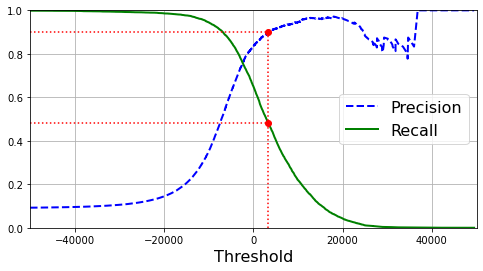

In [78]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                # Not shown
plt.show()



Another way to select good precision/recall tradeoff is to plot precision directly against recall

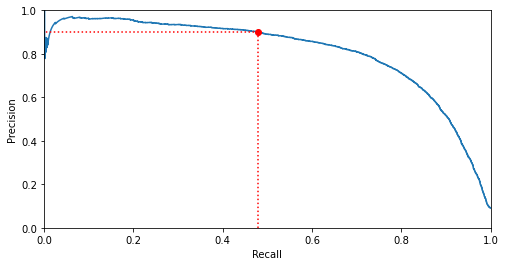

In [79]:
precision_90 = precisions[np.argmax(precisions >= 0.9)]

plt.figure(figsize=(8,4))
plt.plot(recalls, precisions)
plt.plot([recall_90_precision], [precision_90], "ro")
plt.plot([recall_90_precision, 0.0], [precision_90, precision_90], "r:")
plt.plot([recall_90_precision, recall_90_precision], [0.0, precision_90], "r:")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0.0, 1.0, 0.0, 1.0])
plt.show()

Suppose we decide to aim for 90% precision. After looking at first plot we find that we need threshold of 8000. To be more precise, we can search for lowest threshold that gives us at least 90% precision (np.argmax will give us first index of the maximum value which in this case means first true value)

In [80]:
threshold_90_precision = thresholds[np.argmax( precisions >= 0.9)]
print(threshold_90_precision)

3370.019499143958


To make predictions instead of calling classfier's predict method, 

In [81]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [82]:
#Let's check precision and recall
print(f"precision:{precision_score(y_train_5, y_train_pred_90)}, recall:{recall_score(y_train_5, y_train_pred_90)}")

precision:0.9000345901072293, recall:0.4799852425751706


Great! Now we have 90% precision classifier! (High precision classifier is not very useful if it's recall is too low)

### ROC Curve
- ROC curve is another tool used with binary classifiers. It plots true positive rate (just recall / Sensitivity) against false positive rate FPR.
- FPR - Ratio of negative instances that are incorrectly classified as positives (1- TNR)
- TNR (Specificity)- Ratio of negative instances that are correctly classified as negatives
- ROC- plot of Sensitivity vs Specificity

In [83]:
from sklearn.metrics import roc_curve

fpr , tpr , thresholds = roc_curve(y_train_5, y_scores)

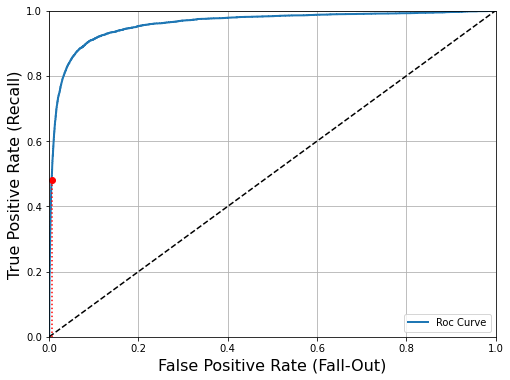

In [84]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)    
    plt.grid(True)
    
        
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr, "Roc Curve")
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.axis([0,1,0,1])
plt.legend()
plt.show()

Again there's tradeoff. Higher the Recall (TPR), higher the FPR. The dotted line represents ROC curve of a purely random classifier. A good classifier stays as far away as possible from the line( towards the top left corner). 

One way to compare classifiers is to measure the Area under the curve AUC. A perfect classifier will have ROC AUC= 1. Whereas purely Random Classifier will have ROC AUC equal to 0.5.

In [85]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

As the ROC curve is so similar to precision/recall or PR curve, rule of thumb for deciding the choice is,
- Prefer PR curve whenever the positive class is rare or when we care more about False Positives than False Negatives.
- Otherwise ROC

Ex. Looking at previous ROC AUC results, we may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to negatives (non-5s).

In contrast, PR curve makes it clear that classifier has room for improvement. (Curve could be closer to top-right corner)

Let's train RandomForestClassfier and compare it's ROC AUC with SGDClassifier

In [86]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                   method='predict_proba')

But to plot ROC curve we need scores and not probabilites. One simple solution is use positive class's probability as score

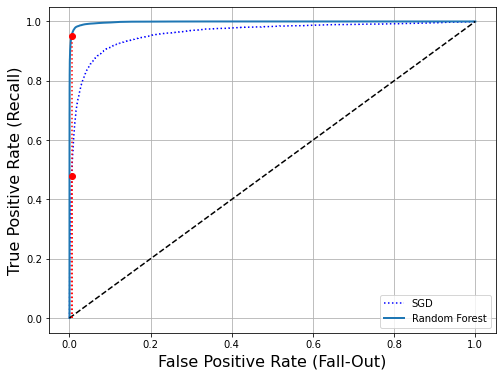

In [87]:
y_scores_forest = y_probas_forest[:, 1] #scores = Proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, "b:",label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([fpr_90],[recall_90_precision],"ro")

plt.plot([fpr_90, fpr_90], [0, recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.legend(loc="lower right")
plt.show()

In above graph, RandomForestClassifier's ROC curve looks much better tahn SGDClassifier's. It comes much closer to the top left corner. As result ROC AUC score is also significantly high

In [88]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

print(f"precision:{precision_score(y_train_5, y_train_pred_forest)}, recall:{recall_score(y_train_5, y_train_pred_forest)}")
roc_auc_score(y_train_5, y_scores_forest)

precision:0.9905083315756169, recall:0.8662608374838591


0.9983436731328145

## Multiclass Classification
#### Using Binary Classifiers
- OvO Startegy- Ex. SVM . Classification is done based on One v One strategy. So for N classes, it will train N x (N-1) / 2 classifiers internally. SVM specially needs very less data to do this per class
- OvA Strategy- Ex. SGDClassifier. Classification is done based on One v All startegy. Trains N classifiers internally

#### Using Multinomial Classifiers
-  Ex. Random Forest, Naive Bayes. These classifiers are capable of multiclass classification without above strategy.

In [89]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])

svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [90]:
some_digit_scores = svm_clf.decision_function([some_digit])  #Now returns 10 scores per instance
some_digit_scores , np.argmax(some_digit_scores) , svm_clf.classes_

(array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
          9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]]),
 5,
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

Forcing Sklearn to use OvO / OvA startegies

In [91]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [92]:
len(ovr_clf.estimators_)  #Would have been 45 in case of OvO

10

In [93]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [94]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [95]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [96]:
#StandardScaling data properly and try again
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled , y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [99]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

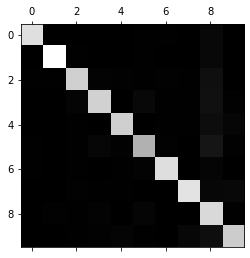

In [100]:
plt.matshow(conf_mx, cmap = plt.cm.gray)  #run again to see original confusion matrix. 
plt.show()

Color for number 5 seems a bit darker. Maybe number of images for class 5 are low or maybe they got classified wrongly more. We can see this by normalizing our errors 

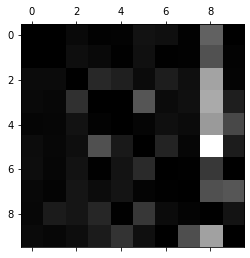

In [98]:
#Normalize errors in percents and make all diagonals zeros to clearly see errors
row_sums = conf_mx.sum(axis=1 , keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

As we can see, color for class 8 column (Predicted 8) is most lighter so many numbers got misclassified as 8. But color for 8 row (Actual 8) is well dark so that means 8 was not misclassified that much.

Also we can see that confusion matrix is not symmetrical. We get to see 3s and 5s often get confused (in both directions - Actual & Predicted)

			Summary of below plot
Classified as 3(Correct) 		 Classified as 5(Incorrect)
Classified as 3(Incorrect) 		 Classified as 5(Correct)


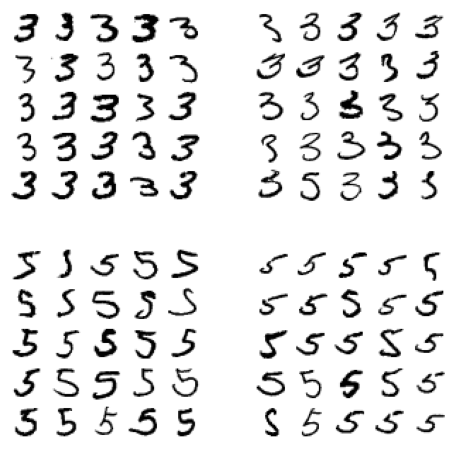

In [123]:
#analyzing individual errors
#Let's plot examples of 3's and 5's.

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [np.reshape(instance, (size,size)) for instance in instances.values]
    
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

print("\t\t\tSummary of below plot")
print("Classified as 3(Correct) \t\t Classified as 5(Incorrect)")
print("Classified as 3(Incorrect) \t\t Classified as 5(Correct)")
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification
ex. A system that recognizes multiple faces in the same picture

In [124]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]  #creates array of two target labels per digit

knn_clf = KNeighborsClassifier() 
knn_clf.fit(X_train, y_multilabel) 

KNeighborsClassifier()

In [125]:
knn_clf.predict([some_digit])  #digit is 5 so it is not large (False) and it's odd (True)

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

f1_score(y_multilabel, y_train_knn_pred, average='macro') #assumes all labels are important equally.
#to give each label it's weight based on number of instances use average="weighted"